# Importing libraries

In [ ]:
import os
import shutil
import random #for random distribution of data
from shutil import copyfile
from os import getcwd  # getcwd returns current working directory
import pandas as pd # for data manipulation
import numpy as np # for operation
import tensorflow as tf
from tensorflow.keras.preprocessing import image # for image processing
import matplotlib.pyplot as plt
from keras.utils import np_utils
import cv2
from zipfile import ZipFile
from google.colab.patches import cv2_imshow

Using TensorFlow backend.


## **Uploding files from local system**

In [ ]:
from zipfile import ZipFile
file_name = 'jaffe.zip'

with ZipFile(file_name,'r') as zip:
  zip.extractall()

## Upload files from Google Drive

1.   In this you need to save your datasets in your drive .
2.   Then mount your drive (if first time you need   authorization code)
3.   At last we flush the drive.




# Specify your dataset


In [ ]:
dataset_name = 'jaffe'

In [ ]:
def import_files_from_google_drive(dataset_name):
  from google.colab import drive
  drive.mount('/content/drive')   # mounting the drive
  
  file_name1 = '/content/drive/My Drive/{}.zip'.format(dataset_name)

  with ZipFile(file_name1,'r') as zip:
    zip.extractall("/content/")
    print("Successfully imported and extracted files from google drive")
  drive.flush_and_unmount()
  print('All changes made in this colab session should now be visible in Drive.')


In [ ]:
import_files_from_google_drive(dataset_name) 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Successfully imported and extracted files from google drive
All changes made in this colab session should now be visible in Drive.


# Accessing the files in the dataset

In [ ]:
path = "/content/{}/".format(dataset_name) # access the path
total_num_of_samples = 0 
num_of_samples = 0
num_of_each_samples = [0]
data_dir_list=os.listdir(path)
shutil.rmtree("/content/{}/".format(dataset_name) +'/tmp', ignore_errors= True)  # remove that directory tree if tmp named directory exists
#class_name = ['anger', 'contempt','disgust','fear','happy','sadness','surprise']
if dataset_name == 'jaffe':
  class_name = ['0', '1','2','3','4','5','6']
else:
  class_name = ['anger', 'contempt','disgust','fear','happy','sadness','surprise']
for name in class_name:
    num_samples = len(os.listdir(path + name))
    print(name +': ', num_samples )
    num_of_each_samples.append(num_samples)
    num_of_samples = num_of_samples + len(os.listdir(path + name))
print(num_of_samples)    

0:  30
1:  30
2:  29
3:  32
4:  31
5:  31
6:  30
213


# Pre-Processing Part

This section includes pre-processing of images of datasets which are face alignment , cropping , histogram equalization , normalization using z-score normalization . 

In [ ]:
from scipy import stats
def HistEqualization(image, number_bins = 256):
  # get the image histogram
  image_Hist, bins = np.histogram(image.flatten(), number_bins, [0, 256])
  cdf = image_Hist.cumsum() # cumulative distribution function
  cdf = image_Hist.max()*cdf/cdf.max()  #normalize
  cdf_mask = np.ma.masked_equal(cdf, 0)
  cdf_mask = (cdf_mask - cdf_mask.min())*255/(cdf_mask.max()-cdf_mask.min())
  cdf = np.ma.filled(cdf_mask,0).astype('uint8')
  return cdf[image.astype('uint8')]

In [ ]:
from PIL import Image
import math
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import dlib
import cv2


In [ ]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bunzip2 "shape_predictor_68_face_landmarks.dat.bz2"

--2020-06-20 11:27:58--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  17.2MB/s    in 3.6s    

2020-06-20 11:28:02 (17.2 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [ ]:
predictor_path = 'shape_predictor_68_face_landmarks.dat'  # path of data

#initializes dlib’s pre-trained face detector based on a modification to the standard Histogram of Oriented Gradients + Linear SVM method for object detection.
detector = dlib.get_frontal_face_detector() 
#loads the facial landmark predictor using the path
predictor = dlib.shape_predictor(predictor_path)


In [ ]:
# take a bounding predicted by dlib and convert it
def rect_to_bb(rect):
	
	# to the format (x, y, w, h) as we would normally do
	# with OpenCV
	x1 = rect.left()
	y1 = rect.top()
	w1 = rect.right() - x1
	h1 = rect.bottom() - y1

	# return a tuple of (x, y, w, h)
	return (x1, y1, w1, h1)
 
# extract 68 coordinate from shape object 
def shape_to_np(shape, dtype = int):
  
  coords = np.zeros((68, 2), dtype=dtype)
  for i in range(0,68):
    coords[i] = (shape.part(i).x, shape.part(i).y)
  return coords # loop over the 68 facial landmarks and convert them

# calculate forehead distance to use in cropping image
def forehead_dist(coords):

  d = (np.sum(coords[42:47,1]) - np.sum(coords[36:41,1]))/ 6
  return d

# calculate angle using eye landmark points i.e 42 to 47 is right eye and 36 to 41 is left eye 
def required_angle(shape):
	
  val = (np.sum(shape[42:47,1]) - np.sum(shape[36:41,1]))/(np.sum(shape[42:47,0]) - np.sum(shape[36:41,0])) 
  angle = math.degrees(math.atan(val))
  return angle

#finally rotate image obtained by required_angle function
def rotate_image(image, shape):
  
  angle = required_angle(shape)
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  rotated_image = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return rotated_image


In [ ]:
def face_alignment(image):

  gray_image = cv2.cvtColor(image ,cv2.COLOR_BGR2GRAY)  # convert color image to grayscale image
  rects = detector(gray_image ,1)             # detect faces in the grayscale image
  if len(rects) > 0:

    images = []
    for (i, rect) in enumerate(rects):
      shape = predictor(image, rect)
      shape = shape_to_np(shape)

      rotated_image = rotate_image(image , shape)
      images.append(rotated_image)
    if len(rects) == 1 :
      return rotated_image
    else:
      return images
  else:
    print("Error : number of detected face is zero, so we just return original image")
    return image
  

   

In [ ]:
def face_cropping_without_forehead(image):

  gray_image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)  # convert color image to grayscale image
  rects = detector(gray_image ,1)             # detect faces in the grayscale image
  if len(rects) > 0:
    images = []
    for (i, rect) in enumerate(rects):
	
      shape = predictor(image, rect)
      shape = shape_to_np(shape)
    
      # convert dlib's rectangle to a OpenCV-style bounding box
      # [i.e., (x, y, w, h)], then draw the face bounding box
      (x1, y1, w1, h1) = rect_to_bb(rect)

      d = forehead_dist(shape)
      top_y = int(np.sum(shape[42 : 47, 1]) / 6 - 0.6 * d)
      left_x, left_y = shape[0]
      bottom_x, bottom_y = shape[8]
      right_x, right_y = shape[16]
      cropped_image = image[top_y : bottom_y, left_x : right_x]
      if cropped_image.shape[0] == 0: 
        cropped_image = image[0:-1,left_x : right_x] 
      if cropped_image.shape[1] == 0:
        cropped_image = image[top_y : bottom_y,  0:-1]
      images.append(cropped_image)
    if len(rects) == 1 :
      return cropped_image
    else:
      return images

  
  else:
    print("Error : number of detected face is zero, so we just return original image")
    return image


In [ ]:
def face_cropping_without_background(image):

  gray_image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)  # convert color image to grayscale image
  rects = detector(gray_image ,1)             # detect faces in the grayscale image
  if len(rects) > 0:
    images = []
    for (i, rect) in enumerate(rects):
	
      shape = predictor(image, rect)
      shape = shape_to_np(shape)
    
      # convert dlib's rectangle to a OpenCV-style bounding box
      # [i.e., (x, y, w, h)], then draw the face bounding box
      (x1, y1, w1, h1) = rect_to_bb(rect)

      top_x, top_y = shape[19]
      left_x, left_y = shape[0]
      bottom_x, bottom_y = shape[8]
      right_x, right_y = shape[16]
      cropped_image = image[ min(top_y, abs(y1)) : max(bottom_y, abs(y1) + w1), min(left_x, abs(x1)) : max(right_x, abs(x1) + w1)]
      if cropped_image.shape[0] == 0: 
        cropped_image = image[:,min(left_x, abs(x1)) : max(right_x, abs(x1) + w1)] 
      if cropped_image.shape[1] == 0:
        cropped_image = image[min(top_y, abs(y1)) : max(bottom_y, abs(y1) + w1), :]
      images.append(cropped_image)
    if len(rects) == 1 :
      return cropped_image
    else:
      return images
  else:
    print("Error : number of detected face is zero, so we just return original image")
    return image


In [ ]:

from google.colab.patches import cv2_imshow
data_dir_list = os.listdir(path)
image_data = []


for dataset in data_dir_list:
    img_list=os.listdir(path+'/'+ dataset)
    
    for img in img_list:
      input_img=cv2.imread(path + '/'+ dataset + '/'+ img  )
      #cv2_imshow(input_img)
      img1 = face_alignment(input_img)
      img2 = face_cropping_without_forehead(img1)
      img2 = cv2.resize(img2,(32,32))
      HEG_image = HistEqualization(img2)
      normalized_img = stats.zscore(HEG_image)
      normalized_img = normalized_img*255
      img = normalized_img
      #cv2_imshow(img)
      image_data.append(img)
      
image_data = np.array(image_data)


In [ ]:
print(image_data.shape)
print(image_data[0].shape)

(213, 32, 32, 3)
(32, 32, 3)


# Splitting the data into training and testing data

In [ ]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

num_of_classes = len(class_name)
num_of_samples = image_data.shape[0]
labels = np.ones((num_of_samples,) , dtype='int64')
print(num_of_classes,num_of_samples)
print(num_of_each_samples)
for i in range( num_of_classes ) :
  labels[np.sum(num_of_each_samples[0 : np.max(i + 1, 0) ]) : np.sum(num_of_each_samples[0 : (i + 2)])] = i


print(len(labels))

def getLabel(id):
    #return ['anger','contempt','disgust','fear','happy','sadness','surprise'][id]
    return ['0','1','2','3','4','5','6'][id]

Y = np_utils.to_categorical(labels, num_of_classes)
 
x,y = image_data,Y

#print(len(x),len(y))
#X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
test_size = 0.2
X_train = []
X_test = []
y_train = []
y_test = []

for i in range(num_of_classes):
  X_train_t , X_test_t, y_train_t, y_test_t = train_test_split( x[np.sum(num_of_each_samples[0 : np.max(i + 1, 0) ]) : np.sum(num_of_each_samples[0 : (i + 2)])],
                                                               y[np.sum(num_of_each_samples[0 : np.max(i + 1, 0) ]) : np.sum(num_of_each_samples[0 : (i + 2)])],
                                                               test_size = test_size
                                                               )
  #print(y_test_t.shape, y_train_t.shape)
  X_train += list(X_train_t)
  X_test += list(X_test_t)
  y_train += list(y_train_t)
  y_test += list(y_test_t)


7 213
[0, 30, 30, 29, 32, 31, 31, 30]
213


In [ ]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

168
168
45
45


In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
print(X_train.shape)
#print(Y_test[1:-1])

(168, 32, 32, 3)


# Making of Model

In [ ]:
def CNN_model_with_0_neurons(num_of_classes):
  model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (5,5), activation = 'relu', name = 'conv2d_1',),
        tf.keras.layers.MaxPooling2D((2,2), name = 'max_pool_1'),
        
        tf.keras.layers.Conv2D(64,(5,5), activation = 'relu', name = 'conv2d_2'),
        tf.keras.layers.MaxPooling2D((2,2), name = 'max_pool_2'),
        
        tf.keras.layers.Flatten(name = 'flatten_1'),
 
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_of_classes,activation = 'softmax')
    ])
  return model

In [ ]:

def CNN_model_with_256_neurons(num_of_classes):
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (5,5), activation = 'relu', name = 'conv2d_1',),
        tf.keras.layers.MaxPooling2D((2,2), name = 'max_pool_1'),
        
        tf.keras.layers.Conv2D(64,(5,5), activation = 'relu', name = 'conv2d_2'),
        tf.keras.layers.MaxPooling2D((2,2), name = 'max_pool_2'),
        
        tf.keras.layers.Flatten(name = 'flatten_1'),

        tf.keras.layers.Dense(256, activation = 'relu', name = "full_connected_1"),

        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_of_classes,activation = 'softmax')
    ])
    return model

In [ ]:
def CNN_model_with_512_neurons(num_of_classes):
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (5,5), activation = 'relu', name = 'conv2d_1',),
        tf.keras.layers.MaxPooling2D((2,2), name = 'max_pool_1'),
        
        tf.keras.layers.Conv2D(64,(5,5), activation = 'relu', name = 'conv2d_2'),
        tf.keras.layers.MaxPooling2D((2,2), name = 'max_pool_2'),
        
        tf.keras.layers.Flatten(name = 'flatten_1'),

        tf.keras.layers.Dense(512, activation = 'relu', name = "full_connected_1"),

        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_of_classes,activation = 'softmax')
    ])
    return model

In [ ]:
def CNN_model_with_1024_neurons(num_of_classes):
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (5,5), activation = 'relu', name = 'conv2d_1',),
        tf.keras.layers.MaxPooling2D((2,2), name = 'max_pool_1'),
        
        tf.keras.layers.Conv2D(64,(5,5), activation = 'relu', name = 'conv2d_2'),
        tf.keras.layers.MaxPooling2D((2,2), name = 'max_pool_2'),
        
        tf.keras.layers.Flatten(name = 'flatten_1'),

        tf.keras.layers.Dense(1024, activation = 'relu', name = "full_connected_1"),

        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_of_classes,activation = 'softmax')
    ])
    return model

# Data Augmentation

In [ ]:
train_datagen = image.ImageDataGenerator(
    rescale= 1./255,
    rotation_range = 2 ,
    horizontal_flip =True,
)
train_datagen.fit(X_train)

validation_datagen = image.ImageDataGenerator(rescale = 1./255,
                                             rotation_range=2,
                                             horizontal_flip = True)
validation_datagen.fit(X_test)
print(len(X_train))

168


Confusion Matrix 

In [ ]:
from sklearn import metrics

#print((X_test))
def build_matrix(model, X_test, y_test):
  X_test = X_test.astype(dtype = float)
  predictions = model.predict(X_test)
  y_pred = predictions 
  matrix = metrics.confusion_matrix(y_test.argmax(axis = 1), y_pred.argmax(axis = 1))
  return matrix




In [ ]:
input_shape = (32,32,3)
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model = CNN_model_with_512_neurons(num_of_classes)
model.compile(optimizer = opt, loss = 'categorical_crossentropy',metrics = ['accuracy'])

class myCallback (tf.keras.callbacks.Callback):
    def steps_per_epoch(self, epoch, logs = {}):
        if logs['accuracy'] > 0.85 :
            print('\nAccuracy reached 85%')
            self.model.stop_training = True

In [ ]:
mycallback = myCallback()
# fits the model on batches with real-time data augmentation:
history = model.fit(train_datagen.flow(X_train, y_train, batch_size=16), 
                              epochs = 100,
                              validation_data=validation_datagen.flow(X_test, y_test, batch_size = 16), 
                              callbacks = [mycallback] )

Epoch 1/100
11/11 [==============================] - 1s 56ms/step - loss: 2.0232 - accuracy: 0.1488 - val_loss: 1.9152 - val_accuracy: 0.2222
Epoch 2/100
11/11 [==============================] - 0s 44ms/step - loss: 1.9201 - accuracy: 0.1964 - val_loss: 1.8609 - val_accuracy: 0.2889
Epoch 3/100
11/11 [==============================] - 1s 46ms/step - loss: 1.8828 - accuracy: 0.1845 - val_loss: 1.8097 - val_accuracy: 0.3333
Epoch 4/100
11/11 [==============================] - 0s 45ms/step - loss: 1.7686 - accuracy: 0.3036 - val_loss: 1.7838 - val_accuracy: 0.3111
Epoch 5/100
11/11 [==============================] - 0s 44ms/step - loss: 1.7359 - accuracy: 0.3512 - val_loss: 1.7359 - val_accuracy: 0.4222
Epoch 6/100
11/11 [==============================] - 0s 44ms/step - loss: 1.7020 - accuracy: 0.3750 - val_loss: 1.6973 - val_accuracy: 0.3556
Epoch 7/100
11/11 [==============================] - 0s 44ms/step - loss: 1.6918 - accuracy: 0.3393 - val_loss: 1.6621 - val_accuracy: 0.5111
Epoch 

In [ ]:
historys = []
historys.append(history)

No handles with labels found to put in legend.


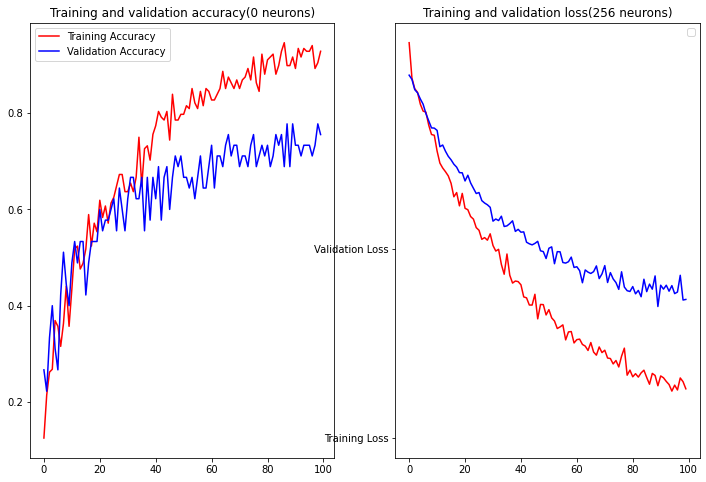

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

for i,history in enumerate(historys):
  acc=history.history['accuracy']
  val_acc=history.history['val_accuracy']
  loss=history.history['loss']
  val_loss=history.history['val_loss']
  epochs=range(len(acc)) # Get number of epochs
  fig = plt.figure(figsize= (12,8))

  plt.subplot(1,2,1)
  plt.plot(epochs, acc, 'r',label =  "Training Accuracy")
  plt.plot(epochs, val_acc, 'b',label = "Validation Accuracy")
  plt.title('Training and validation accuracy({} neurons)'.format(i *256))
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(epochs, loss, 'r', "Training Loss")
  plt.plot(epochs, val_loss, 'b', "Validation Loss")
  plt.legend()
  plt.title('Training and validation loss({} neurons)'.format(256))

  fig.savefig('history_{}neurons.jpg'.format(i *256),bbox_inches='tight', dpi=150)

  plt.show()
  from google.colab import files
  files.download('history_{}neurons.jpg'.format(i *256))


In [ ]:
matrix = build_matrix(model, X_test , y_test)
print(matrix)

[[5 0 0 0 0 1 0]
 [0 6 0 0 0 0 0]
 [0 0 6 0 0 0 0]
 [0 0 1 4 1 1 0]
 [0 1 0 0 6 0 0]
 [0 0 0 0 2 5 0]
 [1 1 0 0 0 2 2]]


In [ ]:
# Just a try to check the use of kfold
for train_ind, test_ind in kf.split(list(range(num_of_samples))):
  print(train_ind,test_ind)
  print(train_ind[1])
  cv2_imshow(image_data[train_ind[1]])

In [ ]:
# ten fold cross validation on the whole dataset 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

acc = 0

kf = KFold(n_splits = 10, random_state = 10, shuffle = True)

kf.get_n_splits(image_data)


for train_index,test_index in kf.split(image_data):

  #print(train_index,test_index)
  x_val_train,x_val_test = image_data[train_index],image_data[test_index]
  y_val_train,y_val_test = Y[train_index], Y[test_index]
  #print( y_val_train,y_val_test)


  
  model = CNN_model_with_0_neurons(num_of_classes)
  model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer='adam',
                  metrics=['accuracy'])
  
  model.fit(x_val_train,y_val_train,epochs=100)
  test_loss,test_acc=model.evaluate(x_val_test,y_val_test)
  print(test_acc)
  acc += test_acc
  #print(test_loss,test_acc )
  #model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  #optimizer='adam',
                  #metrics=['accuracy'])
  #model.fit(x_val_train,y_val_train,epochs=80)
  #test_loss,test_acc=model.evaluate(x_val_test,y_val_test)
#cross_val_score(model,x_val_test,y_val_tes,cv=10)  
print(acc/10)

Epoch 1/100
6/6 [==============================] - 0s 50ms/step - loss: 215.5109 - accuracy: 0.1466
Epoch 2/100
6/6 [==============================] - 0s 48ms/step - loss: 31.7005 - accuracy: 0.1623
Epoch 3/100
6/6 [==============================] - 0s 51ms/step - loss: 7.2675 - accuracy: 0.2461
Epoch 4/100
6/6 [==============================] - 0s 50ms/step - loss: 2.0597 - accuracy: 0.2513
Epoch 5/100
6/6 [==============================] - 0s 48ms/step - loss: 1.8924 - accuracy: 0.1885
Epoch 6/100
6/6 [==============================] - 0s 50ms/step - loss: 1.8874 - accuracy: 0.1623
Epoch 7/100
6/6 [==============================] - 0s 50ms/step - loss: 1.8629 - accuracy: 0.2408
Epoch 8/100
6/6 [==============================] - 0s 49ms/step - loss: 1.8014 - accuracy: 0.2461
Epoch 9/100
6/6 [==============================] - 0s 50ms/step - loss: 1.8128 - accuracy: 0.2513
Epoch 10/100
6/6 [==============================] - 0s 49ms/step - loss: 1.7906 - accuracy: 0.2723
Epoch 11/100
6/6

In [ ]:
# ten fold cross validation on the whole dataset 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

acc = 0

kf = KFold(n_splits = 10, random_state = 10, shuffle = True)

kf.get_n_splits(image_data)
historys_val = []

for train_index,test_index in kf.split(image_data):

  #print(train_index,test_index)
  X_train,X_test = image_data[train_index],image_data[test_index]
  y_train,y_test = Y[train_index], Y[test_index]
  #print( y_val_train,y_val_test)


  
  model = CNN_model_with_0_neurons(num_of_classes)

  model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer='adam',
                  metrics=['accuracy'])
  
  mycallback = myCallback()
  train_datagen = image.ImageDataGenerator(
      rescale= 1./255,
      rotation_range = 2 ,
      horizontal_flip =True,
  )
  train_datagen.fit(X_train)

  validation_datagen = image.ImageDataGenerator(rescale = 1./255,
                                                rotation_range=2,
                                                horizontal_flip = True)
  validation_datagen.fit(X_test)
  print(len(X_train))

  # fits the model on batches with real-time data augmentation:
  history = model.fit(train_datagen.flow(X_train, y_train, batch_size=16), 
                              epochs = 100,
                              validation_data=validation_datagen.flow(X_test, y_test, batch_size = 16), 
                              callbacks = [mycallback] )
  historys_val.append(history)
  #print(test_loss,test_acc )
  #model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  #optimizer='adam',
                  #metrics=['accuracy'])
  #model.fit(x_val_train,y_val_train,epochs=80)
  #test_loss,test_acc=model.evaluate(x_val_test,y_val_test)
#cross_val_score(model,x_val_test,y_val_tes,cv=10)  

In [ ]:
from operator import add 

avg_loss = [0.0]*100
avg_acc = [0.0]*100
avg_val_acc = [0.0]*100
avg_val_loss = [0.0]*100
for i , history in enumerate(historys_val):
  avg_loss = list(map ( add, history.history['loss'], avg_loss))
  avg_acc = list(map(add,history.history['accuracy'], avg_acc))
  avg_val_loss = list(map(add,history.history['val_loss'],avg_val_loss))
  avg_val_acc = list(map(add,history.history['val_accuracy'], avg_val_acc))

fig = plt.figure(figsize= (12,8))
epochs = range(100)
i = 1
plt.subplot(1,2,1)
plt.plot(epochs, avg_acc, 'r',label =  "Training Accuracy")
plt.plot(epochs, avg_val_acc, 'b',label = "Validation Accuracy")
plt.title('Training and validation accuracy({} neurons)'.format(i *256))
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, avg_loss, 'r',label = "Training Loss")
plt.plot(epochs, avg_val_loss, 'b', label = "Validation Loss")
plt.legend()
plt.title('Training and validation loss({} neurons)'.format(i*256))